In [1]:
from src.tools import to_ranges, count_im, xy, Circ
from matplotlib import pyplot as plt
import numpy as np
import cv2 as C
import math as M

BEAD_FREQ = 54
B_POS = (148, 710)
B_SIZ = 25

BEAD_STRIDE = 4
BEAD_SIZE = 7 #px
INTRA_BEAD_DIST = 3.1 #in terms of R

hough = lambda img, **kwargs: np.uint16(np.around(C.HoughCircles(img, **kwargs)))

In [2]:
INTRA_BEAD_DIST = (INTRA_BEAD_DIST + 2)*BEAD_SIZE

B_POS = (B_POS[0], round(B_POS[1] - INTRA_BEAD_DIST))
x0, y0, x1, y1 = xy(B_POS, B_SIZ)

lums = []
cache = {}

for i in range(1, count_im('out_dir') + 1):
  name = f'{i:03d}'
  img = C.imread(f'./out_dir/{name}.png', C.IMREAD_GRAYSCALE)

  # mean lum s.t. lum = sum_white (>200)
  lum = np.sum(img > 200)
  lums.append(lum)
  cache[name] = lum
mean, std = np.mean(lums), np.std(lums)

# delete items in cache that are not in lums
for k in list(cache.keys()):
  if cache[k] < mean + std:
    del cache[k]

ranges = to_ranges(list(map(int, cache.keys())))
print(ranges)

[range(23, 27), range(74, 81)]


In [3]:
# for each range, find the argmax
maxes = {}
for r in ranges:
  argmax = max(r, key=lambda k: cache[f"{k:03d}"])
  maxes[argmax] = cache[f"{argmax:03d}"]

# max in maxes contains the bead
bead = max(maxes, key=lambda k: maxes[k])
img_base = C.imread(f'./in_dir/{bead:03d}.png', C.IMREAD_GRAYSCALE)
img_bead = C.imread(f'./in_dir/{bead - BEAD_FREQ:03d}.png', C.IMREAD_GRAYSCALE)

img_base, img_bead = img_base[x0:x1, y0:y1], img_bead[x0:x1, y0:y1]

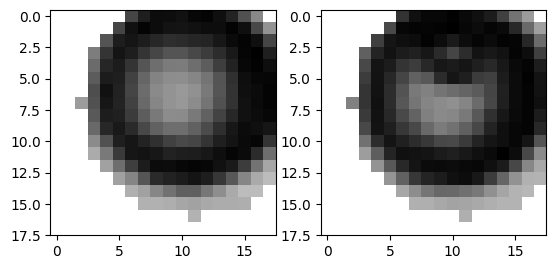

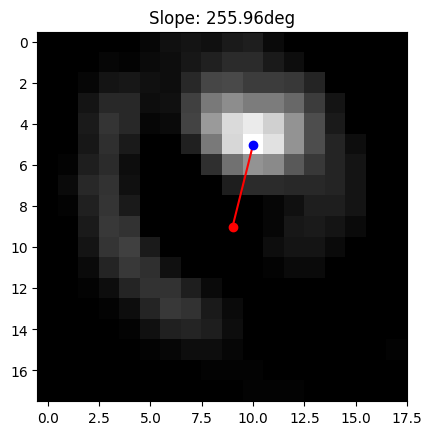

(cx, cy) = (9, 9), bead(x, y) = (5, 10)


In [4]:
img_base2, img_bead2 = Circ(img_base), Circ(img_bead)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_base2, cmap='gray')
axs[1].imshow(img_bead2, cmap='gray')
plt.show()

# add blur to both images
img_base2 = C.GaussianBlur(img_base2, (3, 3), 1)
img_bead2 = C.GaussianBlur(img_bead2, (3, 3), 1)

# plot diff
diff = img_base2 - img_bead2
diff = np.where(diff < 0.68*255, diff, 0)

s = BEAD_STRIDE

max_diff = 0
max_diff_pos = (0, 0)
for i in range(diff.shape[0] - s):
  for j in range(diff.shape[1] - s):
    if np.median(diff[i:i+s, j:j+s]) > max_diff:
      max_diff = np.median(diff[i:i+s, j:j+s])

      max_x = round(np.argmax(diff[i:i+s, j:j+s]) / s)
      max_y = np.argmax(diff[i:i+s, j:j+s]) % s
      max_diff_pos = (i + max_x, j + max_y)
# we can just use openCV's findContour

cx, cy = round(diff.shape[0] / 2), round(diff.shape[1] / 2)
plt.imshow(diff, cmap='gray')
slope = (max_diff_pos[0] - cx) / (max_diff_pos[1] - cy + 1e-6)
slope = round((180-( M.atan(slope) * 180 / M.pi)), 2)
plt.plot([cy, max_diff_pos[1]], [cx, max_diff_pos[0]], 'r')

plt.plot(cx, cy, 'ro')
plt.plot(max_diff_pos[1], max_diff_pos[0], 'bo')
plt.title(f"Slope: {slope}deg")

plt.show()

print(f"(cx, cy) = ({cx}, {cy}), bead(x, y) = {max_diff_pos}")